In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

KNOWN_POINTS_CSV = 'NM/known_points.csv'
REF_POINTS_CSV = 'NM/points.csv'

def read_known_points(known_csv):
    df = pd.read_csv(known_csv)
    print(f"Read {len(df)} known points from {known_csv}")
    return df

# Our goal is to assist the investigation by providing a relative quantification of whether the the device was at the proposed points P1, P2... when it took the evidence E due to GPS error.
known_points_df = read_known_points(KNOWN_POINTS_CSV)
known_points_df

Read 4 known points from NM/known_points.csv


,name,lat,lng
0,P1,45.828472,15.220485
1,P2,45.828432,15.220255
2,P3,45.828386,15.220487
3,E,45.828369,15.220408


In [5]:
def read_measurements_for_proposal(ref_csv, proposal_name):
    df = pd.read_csv(ref_csv)
    needed_columns = ['datetime', 'measured_from', 'lat', 'lng', 'precise']
    df = df[needed_columns]
    df = df[df['measured_from'] == proposal_name]
    df = df[df['precise'] == 'on']
    df = df.drop(columns=['precise'])
    df = df.sort_values(by='datetime', ascending=True, ignore_index=True)
    # flag indicating if two consecutive (by datetime) measurements  are the same (lat, lng)
    df['same_as_prev'] = df[['lat', 'lng']].duplicated(keep='first')
    num_rows = df.shape[0]
    num_duplicates = df['same_as_prev'].sum()
    print(f"Number of measurements for proposal {proposal_name}: {num_rows}")
    print(f"Number of duplicate consecutive measurements: {num_duplicates} ({num_duplicates/num_rows*100:.2f}%)")
    # remove duplicate consecutive measurements
    df = df[df['same_as_prev'] == False]
    df = df.drop(columns=['same_as_prev'])
    df = df.reset_index(drop=True)
    print(f"Clean measurements for proposal {proposal_name}: {df.shape[0]}")
    display(df)
    display(df.describe())
    return df

p1_measurements = read_measurements_for_proposal(REF_POINTS_CSV, 'P1')
p2_measurements = read_measurements_for_proposal(REF_POINTS_CSV, 'P2')
p3_measurements = read_measurements_for_proposal(REF_POINTS_CSV, 'P3')


Number of measurements for proposal P1: 100
Number of duplicate consecutive measurements: 75 (75.00%)
Clean measurements for proposal P1: 25


,datetime,measured_from,lat,lng
0,2024:04:27 13:32:27,P1,45.828472,15.220483
1,2024:04:27 13:32:28,P1,45.828475,15.220481
2,2024:04:27 13:32:28,P1,45.828475,15.220475
3,2024:04:27 13:32:31,P1,45.828481,15.220478
4,2024:04:27 13:32:34,P1,45.828472,15.220486
5,2024:04:27 13:32:38,P1,45.828475,15.220489
6,2024:04:27 13:32:39,P1,45.828475,15.220494
7,2024:04:27 13:32:40,P1,45.828475,15.220492
8,2024:04:27 13:32:44,P1,45.828472,15.220489
9,2024:04:27 13:32:46,P1,45.828472,15.220492


,lat,lng
count,25.000000,25.000000
mean,45.828471,15.220484
std,0.000004,0.000006
min,45.828464,15.220475
25%,45.828469,15.220481
50%,45.828472,15.220483
75%,45.828475,15.220489
max,45.828481,15.220494


Number of measurements for proposal P2: 95
Number of duplicate consecutive measurements: 70 (73.68%)
Clean measurements for proposal P2: 25


,datetime,measured_from,lat,lng
0,2024:04:27 13:34:30,P2,45.828456,15.220189
1,2024:04:27 13:34:32,P2,45.828431,15.220219
2,2024:04:27 13:34:32,P2,45.828433,15.220214
3,2024:04:27 13:34:34,P2,45.828425,15.220222
4,2024:04:27 13:34:35,P2,45.828425,15.220225
5,2024:04:27 13:34:38,P2,45.828425,15.220233
6,2024:04:27 13:34:39,P2,45.828425,15.220239
7,2024:04:27 13:34:40,P2,45.828431,15.220242
8,2024:04:27 13:34:42,P2,45.828431,15.220244
9,2024:04:27 13:34:51,P2,45.828431,15.220247


,lat,lng
count,25.000000,25.000000
mean,45.828433,15.220259
std,0.000007,0.000029
min,45.828425,15.220189
25%,45.828431,15.220239
50%,45.828431,15.220269
75%,45.828433,15.220283
max,45.828456,15.220294


Number of measurements for proposal P3: 94
Number of duplicate consecutive measurements: 80 (85.11%)
Clean measurements for proposal P3: 14


,datetime,measured_from,lat,lng
0,2024:04:27 13:36:33,P3,45.828431,15.220281
1,2024:04:27 13:36:34,P3,45.828431,15.220283
2,2024:04:27 13:36:34,P3,45.828425,15.220286
3,2024:04:27 13:36:35,P3,45.828425,15.220289
4,2024:04:27 13:36:36,P3,45.828422,15.220297
5,2024:04:27 13:36:37,P3,45.828422,15.220300
6,2024:04:27 13:36:38,P3,45.828419,15.220308
7,2024:04:27 13:36:39,P3,45.828414,15.220317
8,2024:04:27 13:36:40,P3,45.828411,15.220325
9,2024:04:27 13:36:41,P3,45.828408,15.220336


,lat,lng
count,14.000000,14.000000
mean,45.828411,15.220353
std,0.000021,0.000110
min,45.828367,15.220281
25%,45.828404,15.220291
50%,45.828417,15.220313
75%,45.828424,15.220344
max,45.828431,15.220608


<Axes: xlabel='lng', ylabel='lat'>

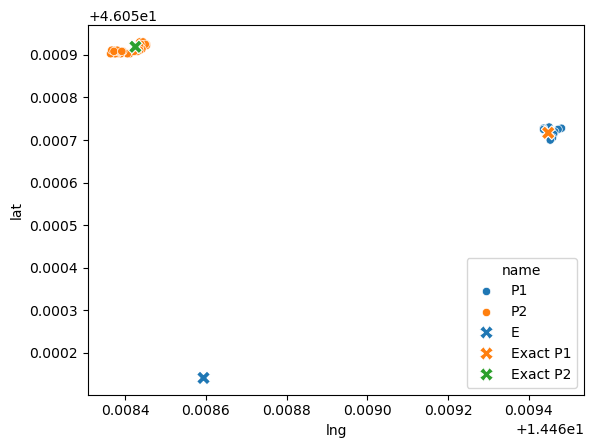

In [ ]:
# visualize points
fig, ax = plt.subplots()
sns.scatterplot(data=proposal_ref_points_df, x='lng', y='lat', hue='ref_point')
sns.scatterplot(data=known_points_df, x='lng', y='lat', hue='name', marker='X', s=100)

In [ ]:
from geographiclib.geodesic import Geodesic

import math
def lat_lng2dist_ang(zero_coords, coords):
    # zero_coords = [lat, lng]
    # coords = [lat, lng]
    # computes distance (in meters) between two points and azimuth (angle from north in radians) of the line using WGS84 ellipsoid, line spins around zero_coords
    # computes angle (in radians) between two points
    results = Geodesic.WGS84.Inverse(zero_coords[0], zero_coords[1], coords[0], coords[1])
    distance = results['s12']
    angle_deg = results['azi1']
    angle = math.radians(angle_deg)
    
    return distance, angle, angle_deg


def prepare_points(exact_proposal_point_lat_lng, proposal_ref_points_df):
    # ref_point = [lat, lng]
    proposal_ref_points_df["dist"] = proposal_ref_points_df.apply(lambda x: lat_lng2dist_ang(exact_proposal_point_lat_lng, [x["lat"], x["lng"]])[0], axis=1)
    proposal_ref_points_df["angle"] = proposal_ref_points_df.apply(lambda x: lat_lng2dist_ang(exact_proposal_point_lat_lng, [x["lat"], x["lng"]])[1], axis=1)
    proposal_ref_points_df["angle_deg"] = proposal_ref_points_df.apply(lambda x: lat_lng2dist_ang(exact_proposal_point_lat_lng, [x["lat"], x["lng"]])[2], axis=1)
    
    return proposal_ref_points_df


p1_refs = proposal_ref_points_df[proposal_ref_points_df['ref_point'] == 'P1'].copy()
p2_refs = proposal_ref_points_df[proposal_ref_points_df['ref_point'] == 'P2'].copy()
p1_refs = prepare_points([P1_lat, P1_lng], p1_refs)
p2_refs = prepare_points([P2_lat, P2_lng], p2_refs)

display(p1_refs)
display(p2_refs)
# TODO: get rid of *consecutive* duplicate rows


,datetime,ref_point,lat,lng,same_ref_point_lat_lng_as_prev,dist,angle,angle_deg
0,2024:04:02 14:19:42,P1,46.050728,14.469481,False,2.803403,1.132911,64.911039
1,2024:04:02 14:19:43,P1,46.050725,14.469472,False,2.088404,1.135859,65.079935
2,2024:04:02 14:19:43,P1,46.050719,14.469464,False,1.276303,1.363691,78.133761
3,2024:04:02 14:19:44,P1,46.050714,14.469461,False,1.093313,1.901560,108.951336
5,2024:04:02 14:19:45,P1,46.050706,14.469458,False,1.520759,2.572826,147.412055
7,2024:04:02 14:19:47,P1,46.050700,14.469453,False,1.938310,2.939471,168.419283
42,2024:04:02 14:20:09,P1,46.050731,14.469450,False,1.507559,0.115765,6.632847
69,2024:04:02 14:20:24,P1,46.050728,14.469436,False,1.491446,-0.648451,-37.153511
79,2024:04:02 14:20:29,P1,46.050725,14.469436,False,1.259244,-0.797082,-45.669437


,datetime,ref_point,lat,lng,same_ref_point_lat_lng_as_prev,dist,angle,angle_deg
100,2024:04:02 14:16:18,P2,46.050925,14.468444,False,1.610993,1.156575,66.266846
102,2024:04:02 14:16:20,P2,46.050925,14.468442,False,1.416840,1.095468,62.765716
119,2024:04:02 14:16:35,P2,46.050931,14.468436,False,1.513638,0.580242,33.245410
121,2024:04:02 14:16:36,P2,46.050931,14.468444,False,1.943553,0.861456,49.357767
123,2024:04:02 14:16:38,P2,46.050925,14.468453,False,2.216637,1.273946,72.991703
124,2024:04:02 14:16:39,P2,46.050922,14.468447,False,1.723525,1.372441,78.635097
126,2024:04:02 14:16:40,P2,46.050922,14.468453,False,2.146723,1.411919,80.897005
128,2024:04:02 14:16:42,P2,46.050925,14.468450,False,2.012044,1.242687,71.200721
131,2024:04:02 14:16:44,P2,46.050925,14.468439,False,1.229636,1.015375,58.176699
132,2024:04:02 14:16:45,P2,46.050914,14.468442,False,1.389666,2.006604,114.969924


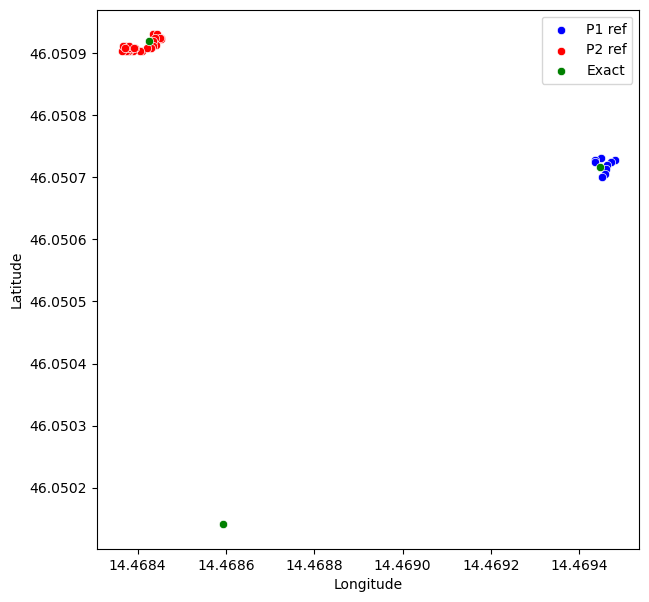

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(data=p1_refs, x="lng", y="lat", ax=ax, label="P1 ref", color="blue")
sns.scatterplot(data=p2_refs, x="lng", y="lat", ax=ax, label="P2 ref", color="red")
sns.scatterplot(data=known_points_df, x="lng", y="lat", ax=ax, label="Exact", color="green")
ax.legend()
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

Max distance in meters from proposal: 5.096317731784229


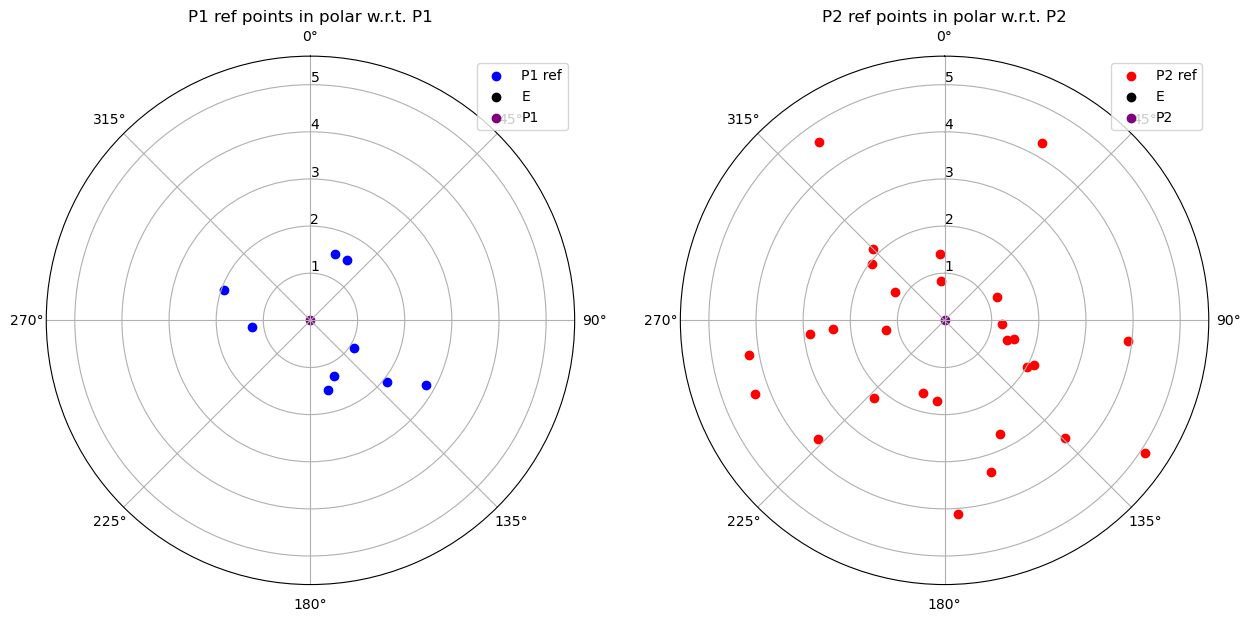

In [ ]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(15,7))
for ax1 in ax.flatten():
    ax1.set_theta_zero_location('N')
    ax1.set_theta_direction(-1)
    ax1.set_rlabel_position(0)
    
max_dist = max(max(p1_refs["dist"]), max(p2_refs["dist"]))
print("Max distance in meters from proposal:", max_dist) # ! we are excluding distance of E here as it's too far for FRI.
max_dist *= 1.1

E_dist_angle_wrt_P1 = lat_lng2dist_ang([P1_lat, P1_lng], [E_lat, E_lng])
E_dist_angle_wrt_P2 = lat_lng2dist_ang([P2_lat, P2_lng], [E_lat, E_lng])

ax[0].set_title("P1 ref points in polar w.r.t. P1")
ax[0].scatter(p1_refs["angle_deg"], p1_refs["dist"], label="P1 ref", color="blue")
ax[0].scatter(E_dist_angle_wrt_P1[1], E_dist_angle_wrt_P1[0], label="E", color="black")
ax[0].scatter(0, 0, label="P1", color="purple")
ax[0].set_rmax(max_dist)
ax[0].legend()


ax[1].set_title("P2 ref points in polar w.r.t. P2")
ax[1].scatter(p2_refs["angle_deg"], p2_refs["dist"], label="P2 ref", color="red")
ax[1].scatter(E_dist_angle_wrt_P2[1], E_dist_angle_wrt_P2[0], label="E", color="black")
ax[1].scatter(0, 0, label="P2", color="purple")
ax[1].set_rmax(max_dist)
ax[1].legend()
plt.show()

# NOTE: E is absolutely too far here (errors are 5m, E is 100m away)


Note: all blue points are taken from the exact same physical spot (P1), same for P2. We can see that error is definitely not uniform in all directions, however, it may be negligible at such low absolute errors (2 vs 5m etc.).

<Axes: xlabel='angle', ylabel='dist'>

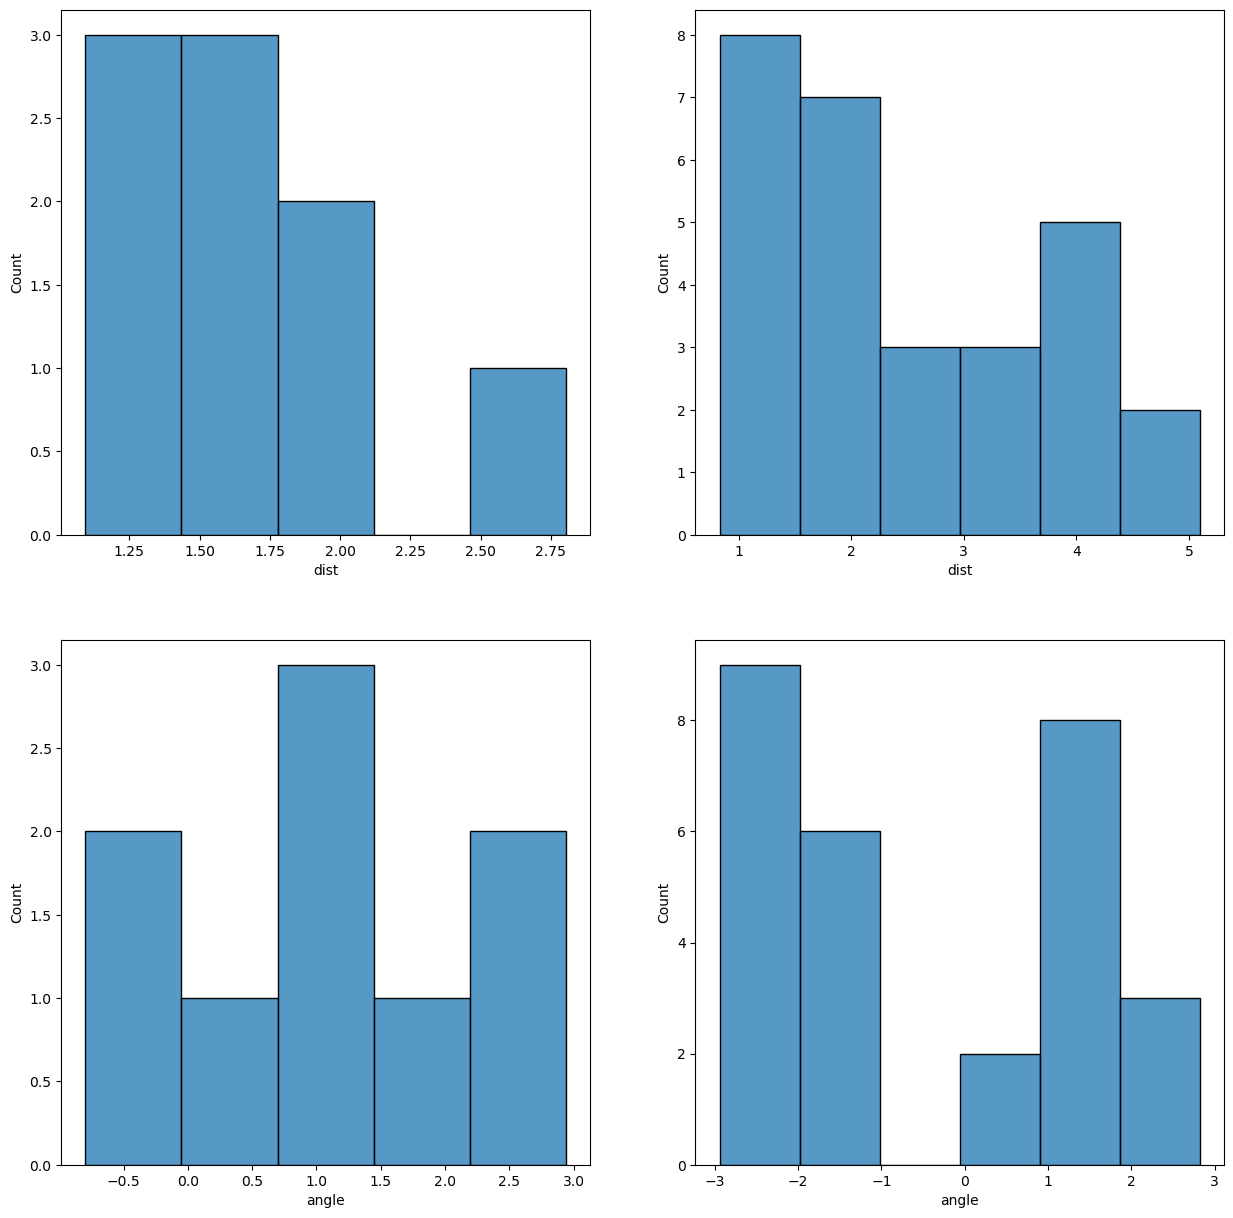

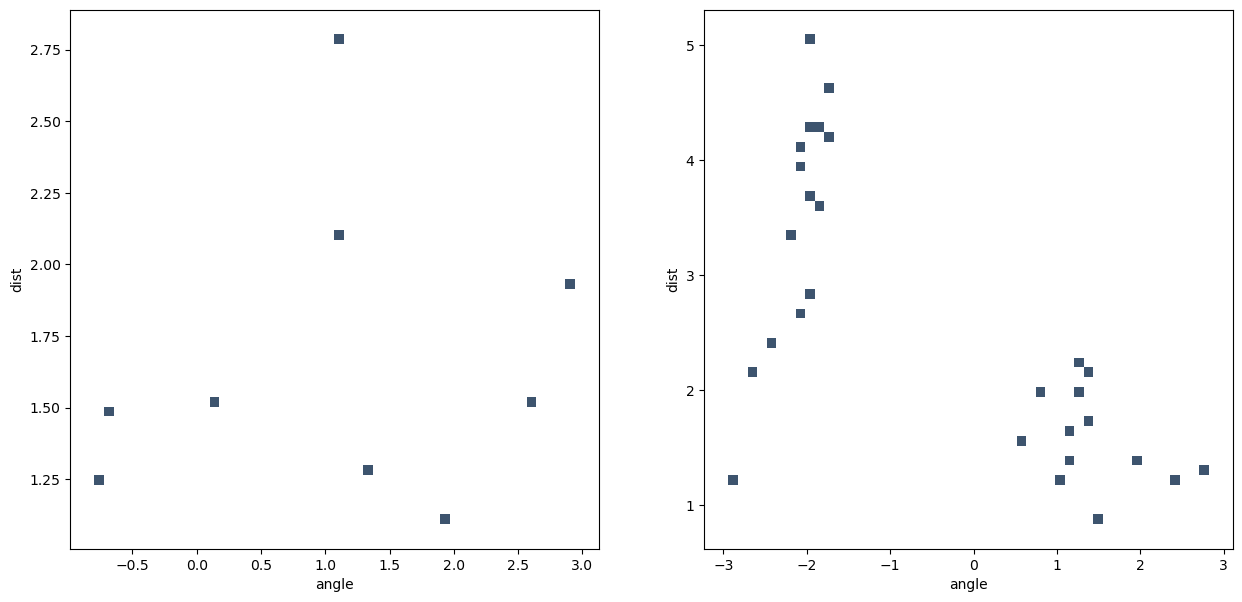

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
sns.histplot(p1_refs["dist"], ax=ax[0, 0])
sns.histplot(p2_refs["dist"], ax=ax[0, 1])
sns.histplot(p1_refs["angle"], ax=ax[1, 0])
sns.histplot(p2_refs["angle"], ax=ax[1, 1])


# Note: ROPE should be defined here for distance and angle
# Note: 2d histograms aren't really reliable here as angle is circular
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
sns.histplot(p1_refs, x="angle", y="dist", bins=50, ax=ax[0])
sns.histplot(p2_refs, x="angle", y="dist", bins=50, ax=ax[1])

In [ ]:
p1_refs

,datetime,ref_point,lat,lng,same_ref_point_lat_lng_as_prev,dist,angle,angle_deg
0,2024:04:02 14:19:42,P1,46.050728,14.469481,False,2.803403,1.132911,64.911039
1,2024:04:02 14:19:43,P1,46.050725,14.469472,False,2.088404,1.135859,65.079935
2,2024:04:02 14:19:43,P1,46.050719,14.469464,False,1.276303,1.363691,78.133761
3,2024:04:02 14:19:44,P1,46.050714,14.469461,False,1.093313,1.901560,108.951336
5,2024:04:02 14:19:45,P1,46.050706,14.469458,False,1.520759,2.572826,147.412055
7,2024:04:02 14:19:47,P1,46.050700,14.469453,False,1.938310,2.939471,168.419283
42,2024:04:02 14:20:09,P1,46.050731,14.469450,False,1.507559,0.115765,6.632847
69,2024:04:02 14:20:24,P1,46.050728,14.469436,False,1.491446,-0.648451,-37.153511
79,2024:04:02 14:20:29,P1,46.050725,14.469436,False,1.259244,-0.797082,-45.669437


In [ ]:
from cmdstanpy import CmdStanModel, cmdstan_path, set_cmdstan_path
import os
set_cmdstan_path('/home/klemen/micromamba/envs/gps/bin/cmdstan') # TODO: extract
import arviz as az

stan_model = CmdStanModel(stan_file='model.stan')

data = {
    'n' : len(p1_refs),
    'x' : p1_refs.loc[:, ['dist', 'angle']].values
}

data

fit = stan_model.sample(data=data, chains=4, iter_warmup=1000, iter_sampling=4000, seed=1, adapt_delta=0.96, parallel_chains=os.cpu_count() // 2)
fit.summary()

/home/klemen/micromamba/envs/gps/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
19:27:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██        | 00:00 Iteration:  900 / 5000 [ 18%]  (Warmup)


chain 1 |████▊     | 00:00 Iteration: 2200 / 5000 [ 44%]  (Sampling)


chain 1 |███████▉  | 00:00 Iteration: 3800 / 5000 [ 76%]  (Sampling)





chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


19:27:18 - cmdstanpy - INFO - CmdStan done processing.
19:27:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -4.42632e-221. (in 'model.stan', line 12, column 4 to column 32)
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in 'model.stan', line 12, column 4 to column 32)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in 'model.stan', line 12, column 4 to column 32)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in 'model.stan', line 12, column 4 to column 32)
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in 'model.stan

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-7.901420,0.039824,2.148860,-12.114000,-7.451040,-5.25454,2911.62,2180.99,1.00125
mu[1],1.664160,0.004755,0.339868,1.134930,1.664900,2.19764,5109.43,3827.29,1.00120
mu[2],1.070230,0.010530,0.851065,-0.247788,1.076930,2.38577,6532.60,4893.33,1.00013
"sigma[1,1]",1.115520,0.029437,2.089850,0.240142,0.686500,3.15389,5040.04,3775.31,1.00107
"sigma[1,2]",0.529406,0.046442,2.983120,-1.635820,0.266345,3.56290,4125.93,3090.59,1.00032
"sigma[2,1]",0.529406,0.046442,2.983120,-1.635820,0.266345,3.56290,4125.93,3090.59,1.00032
"sigma[2,2]",6.839050,0.176633,10.193600,1.464240,4.097200,19.72060,3330.54,2494.78,1.00136


array([[<Axes: title={'center': 'mu\n0'}>,
        <Axes: title={'center': 'mu\n0'}>],
       [<Axes: title={'center': 'mu\n1'}>,
        <Axes: title={'center': 'mu\n1'}>],
       [<Axes: title={'center': 'sigma\n0, 0'}>,
        <Axes: title={'center': 'sigma\n0, 0'}>],
       [<Axes: title={'center': 'sigma\n0, 1'}>,
        <Axes: title={'center': 'sigma\n0, 1'}>],
       [<Axes: title={'center': 'sigma\n1, 0'}>,
        <Axes: title={'center': 'sigma\n1, 0'}>],
       [<Axes: title={'center': 'sigma\n1, 1'}>,
        <Axes: title={'center': 'sigma\n1, 1'}>]], dtype=object)

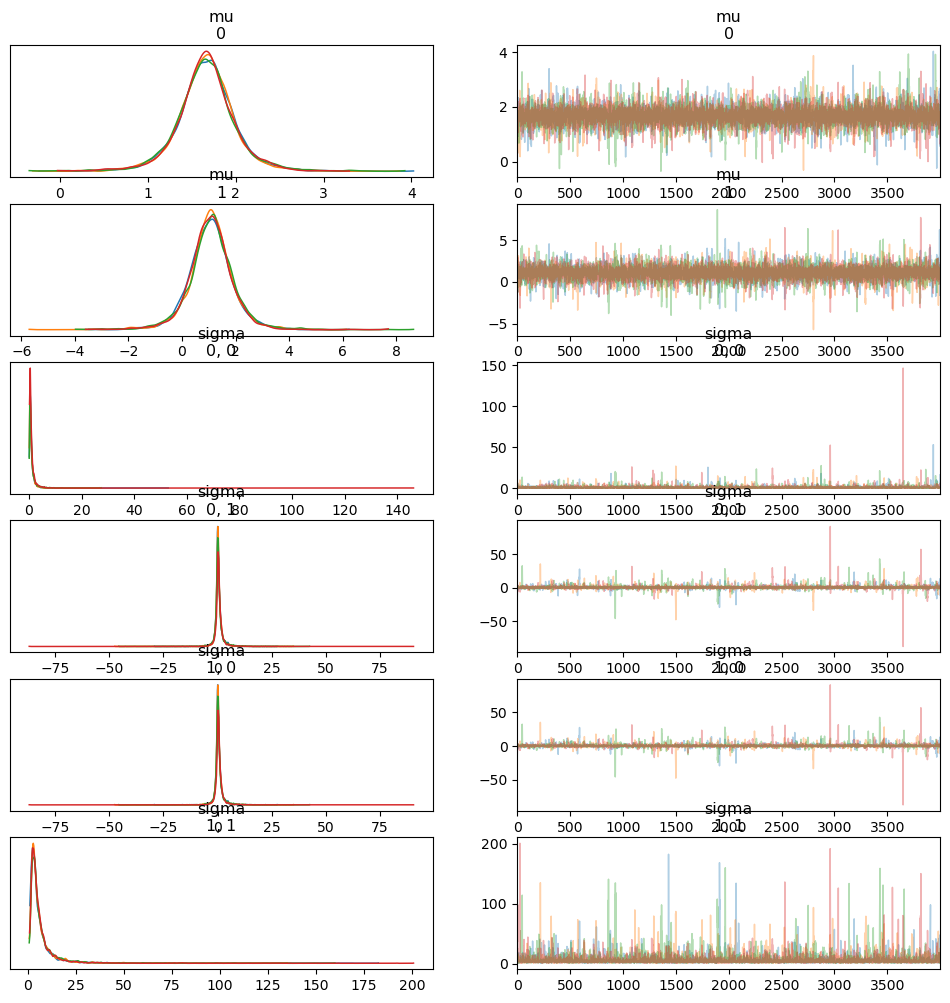

In [ ]:
# traceplots
az.plot_trace(fit, compact=False)

In [ ]:
print(fit.diagnose())

Processing csv files: /tmp/tmptc6iv1w1/model0erll3y_/model-20240730192717_1.csv, /tmp/tmptc6iv1w1/model0erll3y_/model-20240730192717_2.csv, /tmp/tmptc6iv1w1/model0erll3y_/model-20240730192717_3.csv, /tmp/tmptc6iv1w1/model0erll3y_/model-20240730192717_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [ ]:
draws_df = fit.draws_pd()
draws_df

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu[1],mu[2],"sigma[1,1]","sigma[2,1]","sigma[1,2]","sigma[2,2]"
0,1.0,1.0,1.0,-6.77442,0.929105,0.290670,3.0,7.0,0.0,11.42340,1.958160,0.842837,0.643351,0.792965,0.792965,2.73282
1,1.0,2.0,2.0,-5.51433,0.980084,0.290670,3.0,7.0,0.0,9.08503,1.836750,1.233500,0.691737,0.511551,0.511551,1.67195
2,1.0,3.0,3.0,-8.17924,0.718197,0.290670,2.0,3.0,0.0,11.36730,1.902080,1.235370,0.568253,-0.426318,-0.426318,1.32457
3,1.0,4.0,4.0,-8.41069,1.000000,0.290670,3.0,15.0,0.0,9.80941,1.548920,0.452859,0.522777,1.134530,1.134530,13.86170
4,1.0,5.0,5.0,-7.24311,0.977715,0.290670,3.0,15.0,0.0,10.15600,1.330620,0.828343,1.109270,-0.010823,-0.010823,4.42831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,4.0,3996.0,15996.0,-8.89267,0.996119,0.202949,4.0,15.0,0.0,10.20890,1.706050,-0.255033,0.199695,0.397188,0.397188,7.30274
15996,4.0,3997.0,15997.0,-9.70251,0.984815,0.202949,3.0,7.0,0.0,10.76550,1.758370,-0.104682,0.175196,0.399057,0.399057,8.28044
15997,4.0,3998.0,15998.0,-11.34930,0.937434,0.202949,4.0,15.0,0.0,15.61970,0.645955,1.120830,5.951740,0.808064,0.808064,1.33052
15998,4.0,3999.0,15999.0,-12.67580,0.931759,0.202949,4.0,15.0,0.0,18.11320,2.347120,1.104880,3.184120,3.166380,3.166380,15.71030


## Posterior predictive check